# Deep Dive Amazon SageMaker Studio 
_**Gradient Boosted Trees para predecir gastos familiares**_

---

En este demo se va a ver algunas características de Amazon SageMaker Studio. 

* [Amazon SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html)
  * Administrar múltiples experimentos
  * Experimentar con hiperparametros y visualizaciones
* [Model hosting](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html)
  * Creación de endpoints para obtener predicciones
* [SageMaker Model Monitor](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor.html)
  * Monitorear la calidad del modelo

---

## Contenido

1. [Background](#Background) 
  - Que es Amazon Sagemaker
1. [Datos](#Datos) - Preparar el dataset y subirlo a s3
1. [Entrenamiento](#Entrenamiento) - Entrenar el modelo
  - [Amazon SageMaker Experiments](#Amazon-SageMaker-Experiments)
1. [Despliegue](#Despliegue)
1. [Monitoreo](#Monitoreo)


---

## Background

### Que es amazon sagemaker

"Amazon SageMaker es un servicio completamente administrado que brinda a todos los científicos de datos y desarrolladores la capacidad de crear, entrenar e implementar modelos de aprendizaje automático de forma rápida. SageMaker elimina las tareas arduas de cada paso del proceso de aprendizaje automático para que sea más fácil crear modelos de alta calidad."
https://aws.amazon.com/es/sagemaker/

SageMaker brinda todos los componentes que se utilizan en el aprendizaje automático en un único conjunto de herramientas, de forma que la producción de los modelos es más rápida y requiere menos esfuerzo y costos.

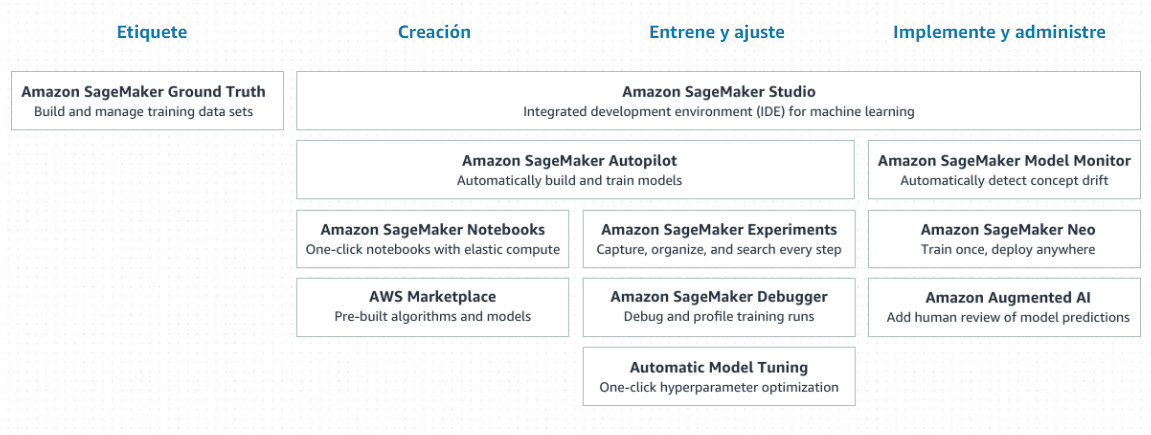

### Predecir gastos familiares con XGBoost

Este notebook es una adaptación de [amazon-sagemaker-examples/aws_sagemaker_studio/getting_started/] (https://github.com/awslabs/amazon-sagemaker-examples.git). 

Se adapta el modelo implementado de gastos familiares para este demo

---
## Datos

Se van a utilizar los datos con la cual se entreno el modelo de gastos familiares: processed_data.csv


In [1]:
import sys
#!{sys.executable} -m pip install sagemaker -U
!{sys.executable} -m pip install -qU awscli boto3 "sagemaker>=1.71.0,<2.0.0"
!{sys.executable} -m pip install sagemaker-experiments


  Using cached sagemaker_experiments-0.1.24-py3-none-any.whl (36 kB)


In [2]:
import io
import os
import sys
import time
import json
import boto3
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import display
from time import strftime, gmtime
from sklearn.model_selection import train_test_split

import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig
from sagemaker.model_monitor import DataCaptureConfig, DatasetFormat, DefaultModelMonitor
from sagemaker.s3 import S3Uploader, S3Downloader
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

print(sagemaker.__version__)

1.72.0


In [3]:
sess = boto3.Session()
sm = sess.client('sagemaker')
role = sagemaker.get_execution_role()
%pwd

'/root'

In [4]:
local_data_path = "/root/demo-sagemaker/notebooks/data/processed_data.csv"
data = pd.read_csv(local_data_path)
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 10)         # Keep the output on one page
data

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,col_0,DIRECTORIO,SECUENCIA_ENCUESTA_x,SECUENCIA_P_x,ORDEN_x,P6050,parentesco,P6020,genero,edad,sq_edad,rango_edad,P6210,P6240,P6390S1,P6510S1,P6510S2,P6585S1A1,P6585S1A2,P6585S2A1,P6585S2A2,P1653S1A1,P1653S1A2,P1653S2A1,P1653S2A2,P1653S3A1,P1653S3A2,P1653S4A1,P1653S4A2,P6750,P6760,P6779S1,P6920,P7510S2A1,P7513S6,P7513S7,P7513S6A1,P7513S7A1,P7513S7A2,VIVIENDA,SECUENCIA_ENCUESTA_y,SECUENCIA_P_y,ORDEN_y,REGION,DOMINIO,P3,P5747,P8520S1,estrato,P5090,dummy_vivienda,P5100S1,P5100S2,P5100S3,P5100S4,P5102,P5103,P5105,P1644M1,P1644M2,P1644M3,P1644M4,P1644M5,P1644M6,P1644M7,P1644S1,P1644S3,P5240,P5230,P6008,PERIODO,IT,ICGU,ICMUG,ICMDUG,GTUG,GCUG,GCMUG,gdu_alimentos_servicios,salario,sq_salario,ingreso_lulo,porcentaje_ingreso,gastos_básicos,salario_hogar,valor_arriendo,servicios_mercados,servicios_vivienda,porcentaje_gasto,valor_gasto,capc_mercado,gdp_alimentos_servicios,Desayuno_DFC,Almuerzo_DFC,Cena_DFC,Merienda_DFC,Desayuno_PFC,Almuerzo_PFC,Cena_PFC,Merienda_PFC,limpieza_cuidado,cuidado_jabones,cuidado_electrodom,alquiler_servicios,servicios_generales,ropa_accesorios,gastos_educacion,matriculas_educacion,medicamentos,consultas_médicas,servicios_salud,cocina_artículos,hogar_artículos,comunicaciones_transporte,otros_comunicacion,vehículo_productos,vehículo_servicios,cultura_recreación,recreación_fiesta,recreación_artículos,gastos_finanzas,misc_mensual,misc_anual,otra_vivienda,renovación_vivienda,gastos_viajes,personas_hogar,bin_porcentaje_ingreso,Desayuno_FC,Almuerzo_FC,Cena_FC,Merienda_FC,gastos_totales,gb_gastos_totales
0,4,118279,1,1,1,1,Jefe,1,Masculino,22,484,20 : 30,5,1,2395.0,NaN,NaN,NaN,NaN,70000.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,2,2,NaN,NaN,NaN,76892|1413|06|0016|0003,1,1,1,PACÍFICA,YUMBO,1,2,1,1.0,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,3,201607,1.945000e+06,1.945000e+06,1.945000e+06,1.945000e+06,1.237871e+06,1.237871e+06,"1237871,33333333",10038.0,1800000,3240000000000,Medio,1.000000,240038,1800000,230000,10038.0,0.0,0.133354,2.400380e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.150000e+04,174500.0,0.0,0.0,0.0,330000.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,1200000.0,0.0,350000.0,0.0,0.000000e+00,0.0,350000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,90 - 100,0.0,0.0,0.0,0.0,2.686038e+06,0.089365
1,11,118295,1,1,1,1,Jefe,1,Masculino,55,3025,50 : 60,6,1,8553.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,2,2,NaN,NaN,NaN,76892|1257|23|0008|0001,1,1,1,PACÍFICA,YUMBO,1,1,1,1.0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,201607,2.100000e+06,2.100000e+06,1.800000e+06,1.680000e+06,6.844633e+05,6.844633e+05,"384463,333333333",9630.0,1800000,3240000000000,Medio,1.000000,23630,1800000,0,23630.0,0.0,0.013128,2.363000e+04,14000.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,0.0,0.000000e+00,37500.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,10000.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,90 - 100,1000.0,0.0,0.0,0.0,7.213000e+04,0.327603
2,30,118353,1,1,1,1,Jefe,1,Masculino,35,1225,30 : 40,5,1,8423.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1,2,25000000.0,NaN,NaN,05001|1054|07|0035|0001,1,1,1,CENTRAL,MEDELLÍN Y A.M.,1,2,1,2.0,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,4,201607,2.525000e+06,2.525000e+06,2.275000e+06,2.275000e+06,9.405617e+05,9.405617e+05,"940561,666666667",101706.0,2200000,4840000000000,Alto,1.000000,384126,2200000,250000,134126.0,0.0,0.174603,3.841260e+05,12500.0,19920.0,0.0,0.0,0.0,0.0,13000.0,38520.0,16500.0,9760.0,6.500000e+03,3000.0,0.0,0.0,0.0,102000.000000,0.0,5833.333333,2000.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25000.000000,1,90 - 100,13000.0,38520.0,16500.0,9760.0,6.062393e+05,0.633621
3,31,118354,1,1,1,1,Jefe,1,Masculino,38,1444,30 : 40,5,1,8422.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,2,2,NaN,NaN,NaN,05001|1054|07|0037|0006

In [5]:
account_id = sess.client('sts', region_name=sess.region_name).get_caller_identity()["Account"]
#artefactos de los componentes se almacenan en este key
bucket = 'lbk-analytics-dev'
prefix = 'sagemaker/demo'

df_model = data[['valor_gasto','edad','salario']]
df_model = df_model[~df_model['valor_gasto'].isnull()]
df_model['edad_salario'] = df_model['edad'] * df_model['salario']

train, test = train_test_split(df_model, test_size=0.4, random_state=42)
test, validate = train_test_split(test, test_size=0.5, random_state=42)

print("Rows df_model:{}".format(df_model.shape)) 
print("Rows train:{}".format(train.shape)) 
print("Rows test:{}".format(test.shape)) 
print("Rows validate:{}".format(validate.shape)) 

test_without_label = test.drop(columns=['valor_gasto'])
print("Rows test_without_label:{}".format(test_without_label.shape)) 

train.to_csv("/root/demo-sagemaker/notebooks/data/train.csv", sep=',', decimal='.', index=False, header=False)
validate.to_csv("/root/demo-sagemaker/notebooks/data/validate.csv", sep=',', decimal='.', index=False, header=False)
test.to_csv("/root/demo-sagemaker/notebooks/data/test.csv", sep=',', decimal='.', index=False, header=False)
test_without_label.to_csv("/root/demo-sagemaker/notebooks/data/test_without_label.csv", sep=',', decimal='.', index=False, header=False)


s3url = S3Uploader.upload('/root/demo-sagemaker/notebooks/data/train.csv', 's3://{}/{}/{}'.format(bucket, prefix,'data'))
print(s3url)

s3url = S3Uploader.upload('/root/demo-sagemaker/notebooks/data/validate.csv', 's3://{}/{}/{}'.format(bucket, prefix,'data'))
print(s3url)

s3url = S3Uploader.upload('/root/demo-sagemaker/notebooks/data/test.csv', 's3://{}/{}/{}'.format(bucket, prefix,'data'))
print(s3url)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Rows df_model:(12317, 4)
Rows train:(7390, 4)
Rows test:(2463, 4)
Rows validate:(2464, 4)
Rows test_without_label:(2463, 3)
s3://lbk-analytics-dev/sagemaker/demo/data/train.csv
s3://lbk-analytics-dev/sagemaker/demo/data/validate.csv
s3://lbk-analytics-dev/sagemaker/demo/data/test.csv


---
## Entrenamiento

Se va a usar la libreria XGBoost (gradient boosted decision trees), y se va a entrenar el modelo con la información que está en el bucket de S3.

Se debe especificar la ubicación de el contenedor con el algoritmo XGBoost

In [10]:
%pwd
#%ls /opt/conda/lib/p
#from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.amazon.amazon_estimator import get_image_uri
docker_image_name = get_image_uri(boto3.Session().region_name, 'xgboost', repo_version='1.0-1')


Para realizar el entrenamiento con los archivos .csv que están el bucket de s3, se crea un s3_inputs


In [11]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/data/train.csv'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/data/validate.csv'.format(bucket, prefix), content_type='csv')

---
### Amazon SageMaker Experiments

Amazon SageMaker Experiments permite monitorear el entrenamiento del modelo, organizar modelos relacionados, configurar los logs de los modelos, tunning de hiperparametros, revisión de versiones anteriores del modelo, y comparación de resultados entre modelos.

Cada bloque de entrenamiento del modelo se llama "experiment trial", y estos bloques pueden ser comparados

In [12]:
sess = sagemaker.session.Session()

create_date = strftime("%Y-%m-%d-%H-%M-%S", gmtime())

#family_expensives_experiment = Experiment.create(experiment_name="Experiment-family-expensives-xgboost-{}".format(create_date),
family_expensives_experiment = Experiment.create(experiment_name="Experiment-family-expensives-xgboost-v2",
                                              description="Using xgboost to predict family expensives", 
                                              sagemaker_boto_client=boto3.client('sagemaker'))

ClientError: An error occurred (ValidationException) when calling the CreateExperiment operation: Experiment names must be unique within an AWS account and region. Experiment with name (Experiment-family-expensives-xgboost-v2) already exists.

In [13]:
hyperparams = {"max_depth":20,
               "subsample":0.5,               
               "eta":0.2,
               "gamma":0.0,
               "min_child_weight":0.0,
               "silent":0,
               "max_delta_step":0.0,
               "colsample_bytree":1.0,
               "colsample_bylevel":1.0,
               "reg_alpha":0.0,
               "nthread":4,
               "scale_pos_weight":1.0,
               "base_score":0.5,
               "seed":1337,                              
               "num_round":10,
               "objective":'reg:squarederror'
}

---
#### Trial 1

Se va a utilizar el algoritmo XGBoost para entrenar y desplegar el modelo.

- Se crea un estimador con los parametros basicos, como el tipo instancias para entrenar y la cantidad, ademas de la ruta de los artefactos generados de la ejecución del modelo.
- Se crea un objeto `Trial` para asociar el experimento con el entrenamiento ejecutado.  

In [14]:
trial = Trial.create(trial_name="Trial-family-expensives-xgboost-v2-{}".format(strftime("%Y-%m-%d-%H-%M-%S", gmtime())), 
                     experiment_name=family_expensives_experiment.experiment_name,
                     sagemaker_boto_client=boto3.client('sagemaker'))

xgb = sagemaker.estimator.Estimator(image_name=docker_image_name,
                                    role=role,
                                    hyperparameters=hyperparams,
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    base_job_name="demo-family-expensives-v2",
                                    sagemaker_session=sess)


xgb.fit({'train': s3_input_train,
         'validation': s3_input_validation}, 
        experiment_config={
            "ExperimentName": family_expensives_experiment.experiment_name, 
            "TrialName": trial.trial_name,
            "TrialComponentDisplayName": "Training",
        }
       )

INFO:sagemaker:Creating training-job with name: demo-family-expensives-v2-2020-09-02-15-51-55-688


2020-09-02 15:51:55 Starting - Starting the training job...
2020-09-02 15:51:58 Starting - Launching requested ML instances......
2020-09-02 15:53:11 Starting - Preparing the instances for training......
2020-09-02 15:54:27 Downloading - Downloading input data......
2020-09-02 15:55:25 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[15:55:29] 7390x3 matrix with 22170 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:r

---
#### Resultados Trial

Se puede revisar las métricas, logs y graficas relacionadas a cada entrenamiento el el tab **Experiments** en Amazon SageMaker Studio. 

Para visualizar los Entrenamientos de los experimentos, se da doble click sobre el experimento. Adicional se pueden ver los entrenamientos de multiples experimentos seleccionadolos con Crtl, y con el menú contextual "Open in trial component list".

Los componentes son ordenados de tal forma que el mejor modelo queda al inicio

#### Información del trial y descarga de modelos

Seleccionado el trial, se pueden ver la información del mismo, graficas, métricas y la ubicación en s3 del modelo.

---
#### Modificando Hiperparametros

Se va a variar el parámetro `min_child_weight`. Para cada valor se va a crear un `trial` diferente, para poder comparar los resultados en Amazon SageMaker Studio.

In [15]:
min_child_weights = [1, 2, 4, 8, 10]

for weight in min_child_weights:
    hyperparams["min_child_weight"] = weight
    trial = Trial.create(trial_name="Trial-family-expensives-xgboost-v1-weight-{}-{}".format(weight,strftime("%Y-%m-%d-%H-%M-%S", gmtime())), 
                         experiment_name=family_expensives_experiment.experiment_name,
                         sagemaker_boto_client=boto3.client('sagemaker'))

    t_xgb = sagemaker.estimator.Estimator(image_name=docker_image_name,
                                          role=role,
                                          hyperparameters=hyperparams,
                                          train_instance_count=1, 
                                          train_instance_type='ml.m4.xlarge',
                                          output_path='s3://{}/{}/output'.format(bucket, prefix),
                                          base_job_name="demo-family-expensives-v1",
                                          sagemaker_session=sess)

    t_xgb.fit({'train': s3_input_train,
               'validation': s3_input_validation},
                wait=False,
                experiment_config={
                    "ExperimentName": family_expensives_experiment.experiment_name, 
                    "TrialName": trial.trial_name,
                    "TrialComponentDisplayName": "Training",
                }
               )

INFO:sagemaker:Creating training-job with name: demo-family-expensives-v1-2020-09-02-16-00-37-117
INFO:sagemaker:Creating training-job with name: demo-family-expensives-v1-2020-09-02-16-00-37-409
INFO:sagemaker:Creating training-job with name: demo-family-expensives-v1-2020-09-02-16-00-39-870
INFO:sagemaker:Creating training-job with name: demo-family-expensives-v1-2020-09-02-16-00-40-210
INFO:sagemaker:Creating training-job with name: demo-family-expensives-v1-2020-09-02-16-00-43-717


---
#### Crear Gráficos

Seleccionando los `trial` que se quieren comparar, se elige **Add chart**. 
En el panel  **Chart Properties**: 
- **Data type** : `Summary Statistics`. 
- **Chart type**: `Scatter plot`. 
- **X axis** : `min_child_weight`. 
- **Y axis**: `validation:error_last` o `validation:error_avg`. 
- **Color**: `trialComponentName`.


---
## Despliegue

Una vez esta entrenado el modelo, se va a hacer el despliegue a un endpoint. Para monitorear el modelo una vez este recibiendo peticiones, se van a agregar configuraciones para capturar la data que se esta enviando al endpoint.

In [16]:
data_capture_prefix = '{}/datacapture'.format(prefix)

endpoint_name = "Endpoint-family-expensives-xgboost-v1-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("EndpointName = {}".format(endpoint_name))

EndpointName = Endpoint-family-expensives-xgboost-v1-2020-09-02-16-11-46


In [ ]:
xgb_predictor = xgb.deploy(initial_instance_count=1, 
                           instance_type='ml.m4.xlarge',
                           endpoint_name=endpoint_name,
                           data_capture_config=DataCaptureConfig(enable_capture=True,
                                                                 sampling_percentage=100,
                                                                 destination_s3_uri='s3://{}/{}'.format(bucket, data_capture_prefix)
                                                                )
                           )

INFO:sagemaker:Creating model with name: demo-family-expensives-v2-2020-09-02-15-51-55-688
INFO:sagemaker:Creating endpoint with name Endpoint-family-expensives-xgboost-v1-2020-09-02-16-11-46


------

### Invocar el modelo desplegado

Como el modelo ya se encuentra desplegado, se pueden hacer predicciones reales con el modelo a través de peticiones http POST. 
El primer paso a realizar es utilizar serializers y deserializers para convertir los datos de test en un arreglo de NumPy.

In [16]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [21]:
print("Sending test traffic to the endpoint {}. \nPlease wait for a minute...".format(endpoint_name))

with open('/root/demo-sagemaker/notebooks/data/test_without_label.csv', 'r') as f:
    i = 0
    for row in f:
        payload = row.rstrip('\n')
        response = xgb_predictor.predict(data=payload)
        time.sleep(0.2)
        i += 1
        if i >30 :
            break
        

Sending test traffic to the endpoint Endpoint-family-expensives-xgboost-v1-2020-08-26-14-45-44. 
Please wait for a minute...


---
### Verificar que la data se ha capturado en S3

Se va a listar los archivos que fueron capturados y almacenados en bucket de s3. El path en el cual se guardan los archivos es el siguiente:

`s3://{destination-bucket-prefix}/{endpoint-name}/{variant-name}/yyyy/mm/dd/hh/filename.jsonl`

In [23]:
from time import sleep

current_endpoint_capture_prefix = '{}/{}'.format(data_capture_prefix, endpoint_name)
for _ in range(10): # wait up to a minute to see captures in S3
    capture_files = S3Downloader.list("s3://{}/{}".format(bucket, current_endpoint_capture_prefix))
    if capture_files:
        break
    sleep(5)

print("Found Data Capture Files:")
print(capture_files)

Found Data Capture Files:
['s3://lbk-analytics-dev/sagemaker/demo/datacapture/Endpoint-family-expensives-xgboost-v1-2020-08-26-14-45-44/AllTraffic/2020/08/26/14/56-08-050-7e26fe80-fe60-4519-93bc-568a366f0190.jsonl', 's3://lbk-analytics-dev/sagemaker/demo/datacapture/Endpoint-family-expensives-xgboost-v1-2020-08-26-14-45-44/AllTraffic/2020/08/26/14/57-08-433-853ec1d0-7b0c-491f-9210-e538a9dd5e45.jsonl', 's3://lbk-analytics-dev/sagemaker/demo/datacapture/Endpoint-family-expensives-xgboost-v1-2020-08-26-14-45-44/AllTraffic/2020/08/26/14/58-08-519-fc059f9a-16e6-4ae1-997c-98489df2cb67.jsonl', 's3://lbk-analytics-dev/sagemaker/demo/datacapture/Endpoint-family-expensives-xgboost-v1-2020-08-26-14-45-44/AllTraffic/2020/08/26/14/59-08-562-fd823fa2-caea-4484-bbfd-0396e4cb4ba9.jsonl', 's3://lbk-analytics-dev/sagemaker/demo/datacapture/Endpoint-family-expensives-xgboost-v1-2020-08-26-14-45-44/AllTraffic/2020/08/26/15/06-39-181-b748329e-f710-4aad-9e4c-314d5dc8653a.jsonl']


Toda la data capturada por el endpoint se guarda en un formato jsonl. A continuación se ve el ejemplo de un archivo capturado.

In [24]:
capture_file = S3Downloader.read_file(capture_files[-1])

print("=====Single Data Capture====")
print(json.dumps(json.loads(capture_file.split('\n')[0]), indent=2)[:2000])

=====Single Data Capture====
{
  "captureData": {
    "endpointInput": {
      "observedContentType": "text/csv",
      "mode": "INPUT",
      "data": "36,2500000,90000000",
      "encoding": "CSV"
    },
    "endpointOutput": {
      "observedContentType": "text/csv; charset=utf-8",
      "mode": "OUTPUT",
      "data": "607216.25",
      "encoding": "CSV"
    }
  },
  "eventMetadata": {
    "eventId": "12c97ff8-1f0a-440f-ac3a-a34674053b26",
    "inferenceTime": "2020-08-26T15:06:39Z"
  },
  "eventVersion": "0"
}


Cada request es capturado en una linea del archivo jsonl. La linea contiene el input y el output del modelo.

---
## Monitoreo

Amazon SageMaker Model Monitor permite monitorear y evaluar la data procesada por los endpoint. Funciona así:

1. Se tiene que crear una linea base para comparar contra el trafico en tiempo real 
2. Cuando la linea base esta lista, se puede evaluar continuamente el trafico contra la linea base. 
3. Se puede enviar trafico sintético para activar las alarmas del monitoreo.

**Este proceso se puede demorar mas de 1 hora porque el pool mas corto de monitoreo es una hora, se va a mostrar resultados obtenidos con otro modelo de forma previa**


### Linea base y monitoreo continuo

#### 1. Sugerencias con el dataset de la linea base (training)

Generalmente, la data de training es un buen dataset para la linea base Se debe tener en cuenta que el datase de training y el dataset de inferencia deben coincidir (Deben tener el mismo numero de features y el tipo de dato de cada una debe corresponder).

Se va a utilizar el dataset de training, pero con los nombres de las columnas para tener el nombre descriptivo las features.

In [27]:
train.to_csv("/root/demo-sagemaker/notebooks/data/training-dataset-with-header.csv", sep=',', decimal='.', index=False, header=True)

baseline_prefix = prefix + '/baselining_v1'
baseline_data_prefix = baseline_prefix + '/data'
baseline_results_prefix = baseline_prefix + '/results'

baseline_data_uri = 's3://{}/{}'.format(bucket,baseline_data_prefix)
baseline_results_uri = 's3://{}/{}'.format(bucket, baseline_results_prefix)
print('Baseline data uri: {}'.format(baseline_data_uri))
print('Baseline results uri: {}'.format(baseline_results_uri))
baseline_data_path = S3Uploader.upload("/root/demo-sagemaker/notebooks/data/training-dataset-with-header.csv", baseline_data_uri)

Baseline data uri: s3://lbk-analytics-dev/sagemaker/demo/baselining_v1/data
Baseline results uri: s3://lbk-analytics-dev/sagemaker/demo/baselining_v1/results


##### Crear un baselining job  con el dataset de entrenamiento

Teniendo la data lista en S3, se va a iniciar el job de la linea base.

In [ ]:
my_default_monitor = DefaultModelMonitor(role=role,
                                         instance_count=1,
                                         instance_type='ml.m5.xlarge',
                                         volume_size_in_gb=20,
                                         max_runtime_in_seconds=3600,
                                        )

baseline_job = my_default_monitor.suggest_baseline(baseline_dataset=baseline_data_path,
                                                   dataset_format=DatasetFormat.csv(header=True),
                                                   output_s3_uri=baseline_results_uri,
                                                   wait=True
)

Cuando el job sea creado, se puede explorar la ruta de `baseline_results_uri` para ver que archivos son persistidos.

In [29]:
print("Found Files:")
S3Downloader.list("s3://{}/{}".format(bucket, baseline_results_prefix))

Found Files:


['s3://lbk-analytics-dev/sagemaker/demo/baselining_v1/results/constraints.json',
 's3://lbk-analytics-dev/sagemaker/demo/baselining_v1/results/statistics.json']

Se tiene el archivo `constraints.json` que tiene la información del los constraints sugeridos. Ademas se tiene el archivo `statistics.json` que tiene la información estadística sobre los datos en la linea base.

In [30]:
baseline_job = my_default_monitor.latest_baselining_job
schema_df = pd.io.json.json_normalize(baseline_job.baseline_statistics().body_dict["features"])
schema_df.head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,name,inferred_type,numerical_statistics.common.num_present,numerical_statistics.common.num_missing,numerical_statistics.mean,numerical_statistics.sum,numerical_statistics.std_dev,numerical_statistics.min,numerical_statistics.max,numerical_statistics.distribution.kll.buckets,numerical_statistics.distribution.kll.sketch.parameters.c,numerical_statistics.distribution.kll.sketch.parameters.k,numerical_statistics.distribution.kll.sketch.data
0,valor_gasto,Fractional,7390,0,6.015379e+05,4.445365e+09,4.198422e+05,0.0,5.682376e+06,"[{'lower_bound': 0.0, 'upper_bound': 568237.6,...",0.64,2048.0,"[[94718.0, 778200.0, 551230.9090909091, 250380..."
1,edad,Integral,7390,0,4.127632e+01,3.050320e+05,1.111598e+01,18.0,8.300000e+01,"[{'lower_bound': 18.0, 'upper_bound': 24.5, 'c...",0.64,2048.0,"[[46.0, 54.0, 30.0, 46.0, 34.0, 35.0, 61.0, 38..."
2,salario,Integral,7390,0,2.789619e+06,2.061529e+10,2.349803e+06,1404000.0,8.000000e+07,"[{'lower_bound': 1404000.0, 'upper_bound': 926...",0.64,2048.0,"[[1800000.0, 4000000.0, 3000000.0, 2000000.0, ..."
3,edad_salario,Integral,7390,0,1.188436e+08,8.782539e+11,1.185125e+08,28500000.0,2.880000e+09,"[{'lower_bound': 28500000.0, 'upper_bound': 31...",0.64,2048.0,"[[82800000.0, 216000000.0, 90000000.0, 9200000..."


In [31]:
constraints_df = pd.io.json.json_normalize(baseline_job.suggested_constraints().body_dict["features"])
constraints_df.head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


,name,inferred_type,completeness,num_constraints.is_non_negative
0,valor_gasto,Fractional,1.0,True
1,edad,Integral,1.0,True
2,salario,Integral,1.0,True
3,edad_salario,Integral,1.0,True


#### 2. Analizando las capturas subsecuentes para temas de calidad de datos

Con el dataset de la linea base, constraints y estadísticas, se va a monitorear y analizar la data enviada al endpoint.

##### Create a schedule
Se va a crear un monitoring schedule para el endpoint. El schedule especifica la periodicidad en que se va a ejecutar un nuevo trabajo de procesamiento para comparar los resultados con la linea base.

In [33]:
# First, copy over some test scripts to the S3 bucket so that they can be used for pre and post processing
code_prefix = '{}/code'.format(prefix)
#pre_processor_script = S3Uploader.upload("/root/demo-sagemaker/notebooks/preprocessor.py", 's3://{}/{}'.format(bucket,code_prefix))
s3_code_postprocessor_uri = S3Uploader.upload("/root/demo-sagemaker/notebooks/postprocessor.py", 's3://{}/{}'.format(bucket,code_prefix))

Se va a crear el model monitoring schedule para el Endpoint creado anteriormente, con los recursos de la linea base (constraints y statistics) que fueron generados anteriormente.

In [34]:
from sagemaker.model_monitor import CronExpressionGenerator
from time import gmtime, strftime

reports_prefix = '{}/reports'.format(prefix)
s3_report_path = 's3://{}/{}'.format(bucket,reports_prefix)

mon_schedule_name = 'demo-family-expensives-xgboost-model-schedule-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
my_default_monitor.create_monitoring_schedule(monitor_schedule_name=mon_schedule_name,
                                              endpoint_input=xgb_predictor.endpoint,
                                              #record_preprocessor_script=pre_processor_script,
                                              post_analytics_processor_script=s3_code_postprocessor_uri,
                                              output_s3_uri=s3_report_path,
                                              statistics=my_default_monitor.baseline_statistics(),
                                              constraints=my_default_monitor.suggested_constraints(),
                                              schedule_cron_expression=CronExpressionGenerator.hourly(),
                                              enable_cloudwatch_metrics=True,
                                             )

INFO:sagemaker:Creating monitoring schedule name demo-xgboost-customer-churn-model-schedule-2020-08-26-16-13-37.



Creating Monitoring Schedule with name: demo-xgboost-customer-churn-model-schedule-2020-08-26-16-13-37


#### 3. Generación de trafico

El siguiente bloque genera trafico al endpoint de forma automática.  Si no hay trafico, el monitoreo de los jobs no se podra ejecutar.

La siguiente celda se tiene que detener manualmente.

In [37]:
from threading import Thread

runtime_client = boto3.client('runtime.sagemaker')

# (just repeating code from above for convenience/ able to run this section independently)
def invoke_endpoint(ep_name, file_name, runtime_client):
    with open(file_name, 'r') as f:
        i=0
        for row in f:
            payload = row.rstrip('\n')
            response = runtime_client.invoke_endpoint(EndpointName=ep_name,
                                          ContentType='text/csv', 
                                          Body=payload)
            response['Body'].read()
            sleep(1)
            i += 1
            if not (i % 100):
                print(i)
            
def invoke_endpoint_forever():
    while True:
        invoke_endpoint(endpoint_name, '/root/demo-sagemaker/notebooks/data/test_without_label.csv', runtime_client)
        
#thread = Thread(target = invoke_endpoint_forever)
#thread.start()
invoke_endpoint_forever()

# Note that you need to stop the kernel to stop the invocations

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


KeyboardInterrupt: 

##### Listar ejecuciones

Una vez el schedule este activo, el job se va a ejecutar en intervalos específicos. El siguiente código muestra las ultimas 5 ejecuciones y se tiene que ejecutar 1 hora después de iniciar la celda anterior para que muestre resultados.

In [38]:
mon_executions = my_default_monitor.list_executions()
if len(mon_executions) == 0:
    print("We created a hourly schedule above and it will kick off executions ON the hour.\nWe will have to wait till we hit the hour...")

while len(mon_executions) == 0:
    print("Waiting for the 1st execution to happen...")
    time.sleep(60)
    mon_executions = my_default_monitor.list_executions()  

In [ ]:
#Evaluate the latest execution and list the generated reports
latest_execution = mon_executions[-1]
latest_execution.wait()

In [40]:
print("Latest execution result: {}".format(latest_execution.describe()['ExitMessage']))
report_uri = latest_execution.output.destination

print("Found Report Files:")
S3Downloader.list(report_uri)

Latest execution result: CompletedWithViolations: Job completed successfully with 1 violations.
Found Report Files:


['s3://lbk-analytics-dev/sagemaker/demo/reports/Endpoint-family-expensives-xgboost-v1-2020-08-26-14-45-44/demo-xgboost-customer-churn-model-schedule-2020-08-26-16-13-37/2020/08/26/17/constraint_violations.json',
 's3://lbk-analytics-dev/sagemaker/demo/reports/Endpoint-family-expensives-xgboost-v1-2020-08-26-14-45-44/demo-xgboost-customer-churn-model-schedule-2020-08-26-16-13-37/2020/08/26/17/constraints.json',
 's3://lbk-analytics-dev/sagemaker/demo/reports/Endpoint-family-expensives-xgboost-v1-2020-08-26-14-45-44/demo-xgboost-customer-churn-model-schedule-2020-08-26-16-13-37/2020/08/26/17/statistics.json']

In [41]:
#If there are any violations compared to the baseline, they will be generated here. Let's list the violations.
violations = my_default_monitor.latest_monitoring_constraint_violations()
pd.set_option('display.max_colwidth', -1)
constraints_df = pd.io.json.json_normalize(violations.body_dict["violations"])
constraints_df.head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,feature_name,constraint_check_type,description
0,valor_gasto,baseline_drift_check,Baseline drift distance: 0.14008753575159524 exceeds threshold: 0.1


In [42]:
#You can plug in the processing job arn for a single execution of the monitoring into this notebook to see more detailed visualizations of the violations and distribution statistics of the data captue that was processed in that execution
latest_execution.describe()['ProcessingJobArn']

'arn:aws:sagemaker:us-east-1:668153774979:processing-job/model-monitoring-202008261700-ac0fda7470a280e9979429f9'